# Contrast pyro between TFP

- https://www.upgrad.com/blog/statistical-programming-in-machine-learning/

In [5]:
import pyro
import torch

import matplotlib.pyplot as plt
import numpy as np

# Univariate distributions [pyro]

- Most distributions in pyro are thin wrapper around Pytorch distributions
    - ```torch.distributions.distribution.Dsitribution```
        - https://pytorch.org/docs/stable/distributions.html
    - interface 차이 between 'torch distribution' and 'Pyro'
        - see https://docs.pyro.ai/en/dev/distributions.html


In [160]:
torch.manual_seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)

## Normal

### initialization

In [8]:
# loc : mean
# scale : std
normal_torch = torch.distributions.Normal(loc=0., scale=1.0)
normal_pyro = pyro.distributions.Normal(loc=0., scale=1.0)

In [13]:
print("normal_torch : ", normal_torch)
print("normal_pyro  : ", normal_pyro)

normal_torch :  Normal(loc: 0.0, scale: 1.0)
normal_pyro  :  Normal(loc: 0.0, scale: 1.0)


### sampling

In [31]:
print(normal_torch.sample(sample_shape=()))
print(normal_torch.sample(sample_shape=(3,)))
print(normal_torch.sample(sample_shape=(3,2)))

tensor(-1.0712)
tensor([ 0.1227, -0.5663,  0.3731])
tensor([[-0.8920, -1.5091],
        [ 0.3704,  1.4565],
        [ 0.9398,  0.7748]])


In [32]:
print(normal_pyro.sample(sample_shape=()))
print(normal_pyro.sample(sample_shape=(3,)))
print(normal_pyro.sample(sample_shape=(3,2)))

tensor(0.1919)
tensor([ 1.2638, -1.2904, -0.7911])
tensor([[-0.0209, -0.7185],
        [ 0.5186, -1.3125],
        [ 0.1920,  0.5428]])


**another way to generate sample**

- Just like a direct call to ```torch.distributions.Normal().rsample()```, this returns a sample from the unit normal distribution. The crucial difference is that this sample is named. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. This is how Pyro can implement the various manipulations that underlie inference algorithms.

In [72]:
print(pyro.sample("my_sample", pyro.distributions.Normal(loc=0, scale=1.0)))

tensor(0.1859)


**visualization**

In [59]:
def plot_2d_scatter(distribution, shape):
    
    samples_2d = distribution.sample(sample_shape=shape)
    
    mean_value = distribution.mean
    
    plt.figure(figsize=(8,4))
    plt.scatter(samples_2d[:,0], samples_2d[:, 1], color='blue', alpha=0.4)
    plt.scatter(mean_value, mean_value, color='red')
    plt.text(mean_value-1, mean_value+0.5, f"mean point : ({mean_value}, {mean_value})", color='red', fontsize=15)

    plt.title("distribution scatter plot", fontsize=15)

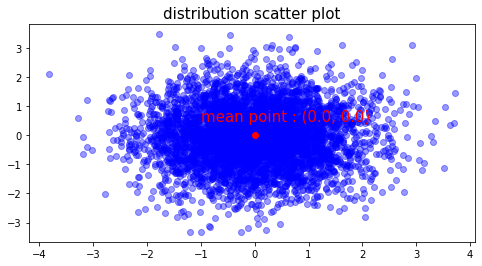

In [60]:
plot_2d_scatter(normal_torch, shape=(5000,2))

#### 'sample' vs 'rsample'

- sample and rsample both generate samples from the distribution, but only rsample supports differentiating through the sampler. 
- You should use rsample whenever you need to compute gradients of distribution parameters with respect to functions of samples, e.g. in variational inference.
    - source : https://forum.pyro.ai/t/sample-vs-rsample/2344/3

In [53]:
print(normal_pyro.rsample(sample_shape=()))
print(normal_pyro.rsample(sample_shape=(3,)))
print(normal_pyro.rsample(sample_shape=(3,2)))

tensor(0.2736)
tensor([-1.2820, -1.3351, -0.5661])
tensor([[ 2.1930,  0.1327],
        [-2.0036,  0.8877],
        [ 1.2258, -0.9201]])


### prob value

- torch, pyro 모두 직접 pdf 값을 return하는 method가 따로 없는 듯..? (말이되나..?)
    - 어쨌든.. 없으니, 일단 ```10**log(prob)``` 으로 prob을 확인하는 수 밖에..?
        - source : https://discuss.pytorch.org/t/in-pytorch-is-there-pdf-logpdf-function-for-distribution/24529/6

In [84]:
print(10**normal_torch.log_prob(torch.FloatTensor([0.5])))
print(10**normal_torch.log_prob(torch.FloatTensor([0.5, 1,3])))

tensor([0.0904])
tensor([9.0378e-02, 3.8112e-02, 3.8112e-06])


In [85]:
print(10**normal_pyro.log_prob(torch.FloatTensor([0.5])))
print(10**normal_pyro.log_prob(torch.FloatTensor([0.5, 1,3])))

tensor([0.0904])
tensor([9.0378e-02, 3.8112e-02, 3.8112e-06])


### log prob value

- return log probability value(pdf)

```
normal.log_prob(0.5) 

>> return log(pdf value of '0.5')
```

In [74]:
print(normal_torch.log_prob(torch.FloatTensor([0.5])))
print(normal_torch.log_prob(torch.FloatTensor([0.5, 1, 3])))

tensor([-1.0439])
tensor([-1.0439, -1.4189, -5.4189])


In [75]:
print(normal_pyro.log_prob(torch.FloatTensor([0.5])))
print(normal_pyro.log_prob(torch.FloatTensor([0.5, 1, 3])))

tensor([-1.0439])
tensor([-1.0439, -1.4189, -5.4189])


## Bernoulli

In [87]:
bern_torch = torch.distributions.Bernoulli(probs = 0.8)
bern_pyro = pyro.distributions.Bernoulli(probs = 0.8)

bern_torch_logit = torch.distributions.Bernoulli(logits = 0.8)
bern_pyro_logit = pyro.distributions.Bernoulli(logits = 0.8)

In [88]:
print("bern_torch : ", bern_torch)
print("bern_pyro  : ", bern_pyro)

bern_torch :  Bernoulli(probs: 0.800000011920929)
bern_pyro  :  Bernoulli(probs: 0.800000011920929)


## "batch_shape"


In [91]:
batched_bernoulli_torch = torch.distributions.Bernoulli(probs=torch.FloatTensor([0.4,0.5]))
batched_bernoulli_pyro = pyro.distributions.Bernoulli(probs=torch.FloatTensor([0.4,0.5]))

In [92]:
print(batched_bernoulli_torch)
print(batched_bernoulli_pyro)

Bernoulli(probs: torch.Size([2]))
Bernoulli(probs: torch.Size([2]))


In [93]:
batched_bernoulli_torch.batch_shape

torch.Size([2])

### batched_bernoulli의 sampling

In [100]:
batched_bernoulli_torch.sample([3])

tensor([[1., 0.],
        [0., 0.],
        [0., 1.]])

In [101]:
batched_bernoulli_pyro.sample([3])

tensor([[0., 1.],
        [1., 1.],
        [0., 1.]])

In [103]:
batched_bernoulli_torch.sample([3,2]).shape

torch.Size([3, 2, 2])

In [104]:
batched_bernoulli_torch.sample([3,2])

tensor([[[1., 1.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [0., 1.]]])

In [105]:
batched_bernoulli_pyro.sample([3,2])

tensor([[[0., 1.],
         [1., 1.]],

        [[1., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.]]])

### bernoulli batch의 probability value, log-probability value

In [129]:
batched_bernoulli_pyro.log_prob(torch.FloatTensor([0,1]))

tensor([-0.5108, -0.6931])

In [130]:
batched_bernoulli_pyro.log_prob(torch.FloatTensor([1,1,1]))

ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([3]) vs torch.Size([2]).

### normal batch

In [133]:
batched_normal = pyro.distributions.Normal(loc=torch.FloatTensor([0, 1, 10]),
                                           scale=torch.FloatTensor([1, 10, 20]))

In [135]:
batched_normal

Normal(loc: torch.Size([3]), scale: torch.Size([3]))

In [137]:
loc_batch_shape = torch.FloatTensor([[0.0, 1.0, 2.0],
                                   [3.0, 4.0, 5.0]])
scale_batch_shape = torch.FloatTensor([[1.0, 2.0, 3.0],
                                     [4.0, 5.0, 6.0]])
batched_normal_2 = pyro.distributions.Normal(loc=loc_batch_shape, scale=scale_batch_shape)
batched_normal_2

Normal(loc: torch.Size([2, 3]), scale: torch.Size([2, 3]))

### normal batch의 sampling

In [139]:
batched_normal.sample([5])

tensor([[  0.3937,  14.0920,  28.2542],
        [  1.5256,  -7.5874, -15.7827],
        [ -0.9706, -14.0027,   7.9708],
        [ -1.5851,   9.3794, -18.7783],
        [  1.1030,   4.2993,  16.6300]])

In [145]:
print("shape : ", batched_normal_2.sample([5]).shape)
batched_normal_2.sample([5])

shape :  torch.Size([5, 2, 3])


tensor([[[-0.7998, -2.8661,  2.4050],
         [ 9.9534,  6.4306,  4.1055]],

        [[ 0.6658,  1.3058,  2.0186],
         [ 3.9691,  1.2397, 10.8636]],

        [[ 0.9711,  3.0644,  3.2933],
         [ 0.7039,  8.8216,  7.4999]],

        [[ 1.1242,  3.1992,  4.3094],
         [-3.6904,  5.6640, 13.2983]],

        [[-0.1218,  1.5384,  1.2411],
         [ 4.8311, -2.6171,  1.2741]]])